In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = "/content/drive/My Drive/Braintumordetection/"
os.listdir(folder_path)  # List files in the folder

['brain_tumor_dataset',
 'no',
 'yes',
 'Augmented_data',
 'tumorous_and_nontumorous',
 'model_01.h5',
 'model_02.h5',
 'model_03.h5']

In [ ]:
# #Loading Dataset and filename consistency
# folder = '/content/drive/My Drive/Braintumordetection/brain_tumor_dataset/yes/'
# count = 1

# for filename in os.listdir(folder):
#     source = folder + filename
#     destination = folder + "Y_" + str(count) + ".jpg"
#     os.rename(source,destination)
#     count += 1

# print("All files successfully renamed to new format!")

In [ ]:
# folder1 = '/content/drive/My Drive/Braintumordetection/brain_tumor_dataset/no/'
# count1 = 1

# for filename in os.listdir(folder1):
#     source1 = folder1 + filename
#     destination1 = folder1 + "N_" + str(count1) + ".jpg"
#     os.rename(source1,destination1)
#     count1 += 1

# print("All files successfully renamed to new format!")

EDA

In [ ]:
# Exploratory Data Analysis
list_yes = os.listdir("/content/drive/My Drive/Braintumordetection/brain_tumor_dataset/yes/")
count_yes = len(list_yes)
print(f"Number of images in yes: {count_yes}")


list_no = os.listdir("/content/drive/My Drive/Braintumordetection/brain_tumor_dataset/no/")
count_no = len(list_no)
print(f"Number of images in no: {count_no}")

Number of images in yes: 155
Number of images in no: 98


Data Augmentation

In [ ]:
total_images = count_yes + count_no
perc_yes = count_yes/total_images * 100
perc_no = count_no/total_images * 100
print(f"YES : {perc_yes}%")
print(f"NO : {perc_no}%")

#Hence we see that there is an imbalance in both

YES : 61.26482213438735%
NO : 38.73517786561265%


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def timing(sec_elapsed):
  h = int(sec_elapsed / 3600)
  m = int(sec_elapsed % (3600) / 60)
  s = int(sec_elapsed % 60)
  return f"{h} : {m} : {s}"

In [ ]:
def augment_data(file_dir, n_generated_sample, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range = (0.3,1.0),
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')

    for filename in os.listdir(file_dir):
      file_path = os.path.join(file_dir, filename)
      image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
      image = np.expand_dims(image, axis=-1)  # Add channel dimension (height, width) → (height, width, 1)
      image = np.expand_dims(image, axis=0)  # Add batch dimension (1, height, width, 1)
      save_prefix = 'aug_' + filename.rsplit('.', 1)[0]
      i = 0
      for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format='jpg'):
          i += 1
          if i > n_generated_sample:
              break

In [ ]:
import time
start_time = time.time()

yes_path = "/content/drive/My Drive/Braintumordetection/brain_tumor_dataset/yes"
no_path = "/content/drive/My Drive/Braintumordetection/brain_tumor_dataset/no"

augmented_data_path = "/content/drive/My Drive/Braintumordetection/Augmented_data"

augment_data(file_dir = yes_path, n_generated_sample = 6, save_to_dir = augmented_data_path + '/yes')
augment_data(file_dir = no_path, n_generated_sample = 9, save_to_dir = augmented_data_path + '/no')

end_time = time.time()
exe_time = end_time - start_time

print(f"Time required for execution is {exe_time}")

Time required for execution is 61.25501370429993


In [ ]:
aug_yes_path = "/content/drive/My Drive/Braintumordetection/Augmented_data/yes/"
aug_no_path = "/content/drive/My Drive/Braintumordetection/Augmented_data/no/"

pos = len(os.listdir(aug_yes_path))
neg = len(os.listdir(aug_no_path))

pos_perc = pos / (pos + neg) * 100
neg_perc = neg / (pos + neg) * 100
print(pos)
print(neg)
print(f"YES : {pos_perc}%")
print(f"NO : {neg_perc}%")

1084
979
YES : 52.544837615123605%
NO : 47.455162384876395%


Data Preprocessing

Convert BGR to GRAY
GaussianBlur
Threshold
Erode
Dilate
Find Contours

In [ ]:
from types import new_class
import imutils
def crop_brain_tumor(image, plot=False):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)

  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.tick_params(axis='both', which='both',
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(new_image)

    plt.tick_params(axis='both', which='both',
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    plt.title('Cropped Image')
    plt.show()


  return new_image

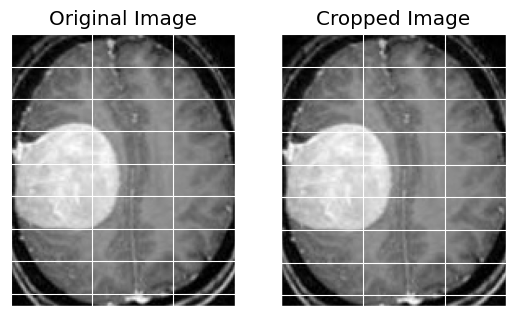

array([[[6, 6, 6],
        [5, 5, 5],
        [7, 7, 7],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]],

       [[8, 8, 8],
        [7, 7, 7],
        [9, 9, 9],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2]],

       [[6, 6, 6],
        [6, 6, 6],
        [7, 7, 7],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2]],

       ...,

       [[3, 3, 3],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [4, 4, 4],
        [4, 4, 4]],

       [[3, 3, 3],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [5, 5, 5],
        [4, 4, 4]],

       [[2, 2, 2],
        [1, 1, 1],
        [3, 3, 3],
        ...,
        [1, 1, 1],
        [4, 4, 4],
        [3, 3, 3]]], dtype=uint8)
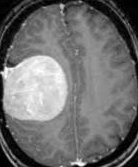

In [ ]:
img = cv2.imread('/content/drive/My Drive/Braintumordetection/Augmented_data/yes/aug_Y_1_0_876.jpg')
crop_brain_tumor(img, True)

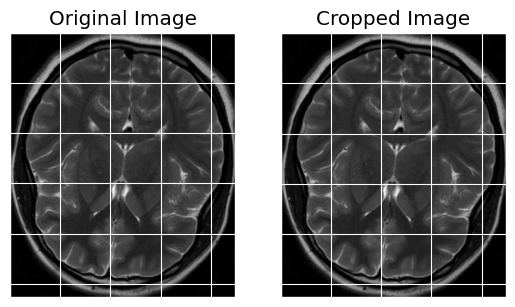

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
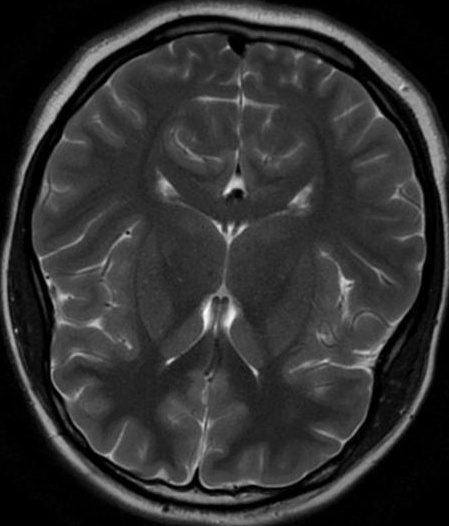

In [ ]:
img = cv2.imread('/content/drive/My Drive/Braintumordetection/Augmented_data/no/aug_N_1_0_9588.jpg')
crop_brain_tumor(img, True)

Image Loading

In [ ]:
folder2 = "/content/drive/My Drive/Braintumordetection/Augmented_data/yes/"
folder1 = "/content/drive/My Drive/Braintumordetection/Augmented_data/no/"

for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, plot=False)
    cv2.imwrite(folder2 + filename, img)

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, plot=False)
    cv2.imwrite(folder1 + filename, img)

In [ ]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
  X = []
  y = []
  image_width, image_height = image_size
  for directory in dir_list:
    for filename in os.listdir(directory):
      image = cv2.imread(directory + '/' + filename)
      image = crop_brain_tumor(image, plot=False)
      image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
      image = image / 255.00
      X.append(image)
      if directory[:-3] == "yes":
        y.append(1)
      else:
        y.append(0)
  X = np.array(X)
  y = np.array(y)

  X,y = shuffle(X,y)
  print(f"Number of examples is: {len(X)}")
  print(f"X shape is: {X.shape}")
  print(f"y shape is: {y.shape}")

  return X, y

In [ ]:
aug_yes_path = "/content/drive/My Drive/Braintumordetection/Augmented_data/yes/"
aug_no_path = "/content/drive/My Drive/Braintumordetection/Augmented_data/no/"

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([aug_yes_path,aug_no_path], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of examples is: 2063
X shape is: (2063, 240, 240, 3)
y shape is: (2063,)


Data Splitting Train Test Validation

In [ ]:
infected_train_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/train/tumorous/"
infected_test_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/test/tumorous/"
infected_valid_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/valid/tumorous/"
healthy_train_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/train/nontumorous/"
healthy_test_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/test/nontumorous/"
healthy_valid_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/valid/nontumorous/"

In [ ]:
files = os.listdir("/content/drive/My Drive/Braintumordetection/Augmented_data/yes/")
fnames = []
for i in range(0,759):
  fnames.append(files[i])

for fname in fnames:
  src = os.path.join("/content/drive/My Drive/Braintumordetection/Augmented_data/yes/", fname)
  dst = os.path.join(infected_train_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir("/content/drive/My Drive/Braintumordetection/Augmented_data/yes/")
fnames = []
for i in range(759,922):
  fnames.append(files[i])

for fname in fnames:
  src = os.path.join("/content/drive/My Drive/Braintumordetection/Augmented_data/yes/", fname)
  dst = os.path.join(infected_test_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir("/content/drive/My Drive/Braintumordetection/Augmented_data/yes/")
fnames = []
for i in range(922,1084):
  fnames.append(files[i])

for fname in fnames:
  src = os.path.join("/content/drive/My Drive/Braintumordetection/Augmented_data/yes/", fname)
  dst = os.path.join(infected_valid_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir("/content/drive/My Drive/Braintumordetection/Augmented_data/no/")
fnames = []
for i in range(0,686):
  fnames.append(files[i])

for fname in fnames:
  src = os.path.join("/content/drive/My Drive/Braintumordetection/Augmented_data/no/", fname)
  dst = os.path.join(healthy_train_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir("/content/drive/My Drive/Braintumordetection/Augmented_data/no/")
fnames = []
for i in range(686,833):
  fnames.append(files[i])

for fname in fnames:
  src = os.path.join("/content/drive/My Drive/Braintumordetection/Augmented_data/no/", fname)
  dst = os.path.join(healthy_test_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
files = os.listdir("/content/drive/My Drive/Braintumordetection/Augmented_data/no/")
fnames = []
for i in range(833,979):
  fnames.append(files[i])

for fname in fnames:
  src = os.path.join("/content/drive/My Drive/Braintumordetection/Augmented_data/no/", fname)
  dst = os.path.join(healthy_valid_dir, fname)
  shutil.copyfile(src, dst)

Model Building

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   horizontal_flip = 0.4,
                                   vertical_flip = 0.4,
                                   rotation_range = 40,
                                   shear_range = 0.2,
                                   width_shift_range = 0.4,
                                   height_shift_range = 0.4,
                                   fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/train/', batch_size = 32, target_size = (240,240), class_mode = 'categorical', shuffle = True, seed = 42, color_mode = 'rgb')

Found 1445 images belonging to 2 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/test/', batch_size = 32, target_size = (240,240), class_mode = 'categorical', shuffle = True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/valid/', batch_size = 32, target_size = (240,240), class_mode = 'categorical', shuffle = True, seed = 42, color_mode = 'rgb')

Found 308 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [ ]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)
base.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=base.input, outputs=outputs)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [ ]:
history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4900 - loss: 0.7247

46/46 ━━━━━━━━━━━━━━━━━━━━ 415s 9s/step - accuracy: 0.4902 - loss: 0.7244 - val_accuracy: 0.4740 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.5084 - loss: 0.7086

46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 724ms/step - accuracy: 0.5084 - loss: 0.7085 - val_accuracy: 0.5260 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 669ms/step - accuracy: 0.5117 - loss: 0.7067 - val_accuracy: 0.4740 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.4882 - loss: 0.7047

46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 686ms/step - accuracy: 0.4881 - loss: 0.7047 - val_accuracy: 0.5260 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 704ms/step - accuracy: 0.5129 - loss: 0.7107 - val_accuracy: 0.5260 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 678ms/step - accuracy: 0.5355 - loss: 0.7042 - val_accuracy: 0.4740 - val_loss: 0.7031 - learning_rate: 0.0010
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 679ms/step - accuracy: 0.5149 - loss: 0.7051 - val_accuracy: 0.5260 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.4901 - loss: 0.7037

46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - accuracy: 0.4903 - loss: 0.7036 - val_accuracy: 0.5260 - val_loss: 0.6918 - learning_rate: 5.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 698ms/step - accuracy: 0.5011 - loss: 0.6973 - val_accuracy: 0.5260 - val_loss: 0.6922 - learning_rate: 5.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 673ms/step - accuracy: 0.4855 - loss: 0.7070 - val_accuracy: 0.4740 - val_loss: 0.6939 - learning_rate: 5.0000e-04


In [ ]:
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4758 - loss: 0.7193 - val_accuracy: 0.5260 - val_loss: 0.6920 - learning_rate: 1.0000e-05
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 703ms/step - accuracy: 0.4837 - loss: 0.7111 - val_accuracy: 0.5260 - val_loss: 0.6921 - learning_rate: 1.0000e-05
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 683ms/step - accuracy: 0.4972 - loss: 0.7042 - val_accuracy: 0.5260 - val_loss: 0.6920 - learning_rate: 1.0000e-05
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 671ms/step - accuracy: 0.4988 - loss: 0.7017 - val_accuracy: 0.5260 - val_loss: 0.6919 - learning_rate: 1.0000e-05
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 700ms/step - accuracy: 0.5185 - loss: 0.6999 - val_accuracy: 0.5260 - val_loss: 0.6921 - learning_rate: 1.0000e-05
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.4995 - loss: 0.6967

46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 677ms/step - accuracy: 0.4999 - loss: 0.6967 - val_accuracy: 0.5260 - val_loss: 0.6917 - learning_rate: 1.0000e-05
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 663ms/step - accuracy: 0.5048 - loss: 0.6934 - val_accuracy: 0.5260 - val_loss: 0.6922 - learning_rate: 1.0000e-05
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 692ms/step - accuracy: 0.4876 - loss: 0.7018 - val_accuracy: 0.5260 - val_loss: 0.6921 - learning_rate: 1.0000e-05
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.5082 - loss: 0.6971 - val_accuracy: 0.5260 - val_loss: 0.6926 - learning_rate: 1.0000e-05
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 688ms/step - accuracy: 0.4936 - loss: 0.6996 - val_accuracy: 0.4708 - val_loss: 0.6940 - learning_rate: 5.0000e-06


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 89s 9s/step - accuracy: 0.5134 - loss: 0.6931
Test accuracy: 0.5258


Class weights: {0: np.float64(1.0532069970845481), 1: np.float64(0.9519104084321476)}
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,02

 Total params: 26,464,961 (100.96 MB)

 Trainable params: 6,439,937 (24.57 MB)

 Non-trainable params: 20,025,024 (76.39 MB)

Epoch 1/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6491 - loss: 0.7541 - val_accuracy: 0.5260 - val_loss: 4.6991 - learning_rate: 0.0010
Epoch 2/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 656ms/step - accuracy: 0.7863 - loss: 0.4558 - val_accuracy: 0.7208 - val_loss: 0.6662 - learning_rate: 0.0010
Epoch 3/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 687ms/step - accuracy: 0.8668 - loss: 0.3183 - val_accuracy: 0.8312 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 4/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 674ms/step - accuracy: 0.9068 - loss: 0.2282 - val_accuracy: 0.8377 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 5/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 637ms/step - accuracy: 0.9168 - loss: 0.2150 - val_accuracy: 0.8409 - val_loss: 0.4162 - learning_rate: 0.0010
Epoch 6/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 662ms/step - accuracy: 0.9039 - loss: 0.2292 - val_accuracy: 0.8571 - val_loss: 0.3730 - learning_rate: 0.0010
Epoch 1/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 889ms/step - accuracy: 0.7965 - loss: 0.5682 - val

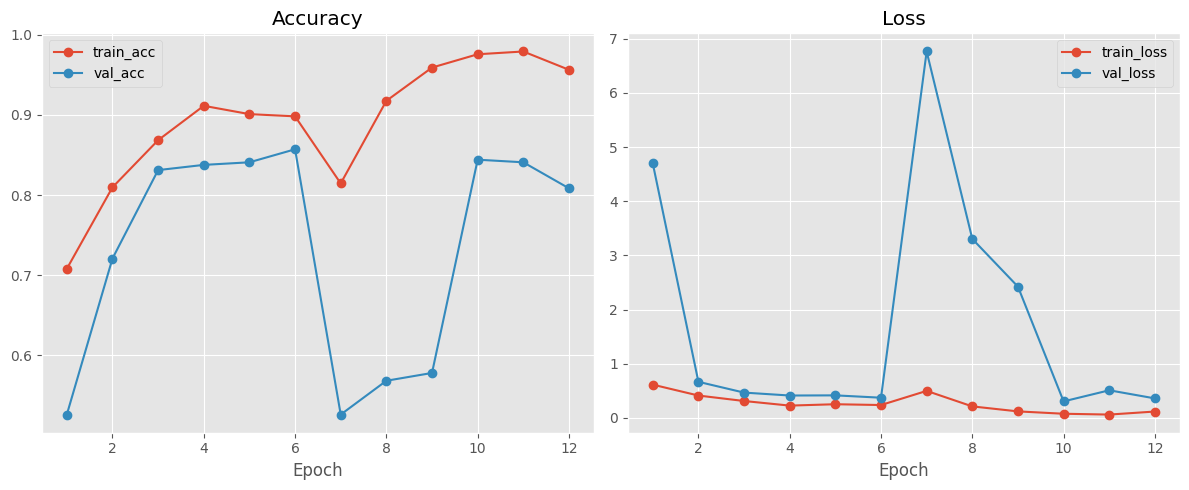

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7320 - loss: 1.2876

Test accuracy: 0.8194, loss: 0.6966
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step


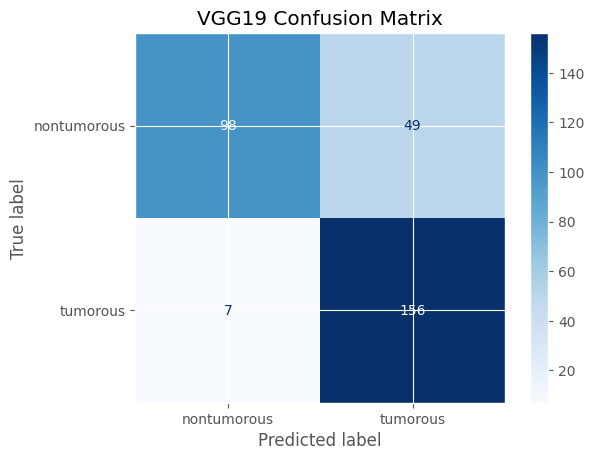

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Imports & (Optional) Focal Loss
# ──────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Optional focal loss (uncomment if you want)
# from tensorflow.keras import backend as K
# def binary_focal_loss(gamma=2.0, alpha=0.25):
#     def loss(y_true, y_pred):
#         y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
#         ce = - (y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred))
#         w = alpha * y_true * K.pow(1-y_pred, gamma) + (1-alpha)*(1-y_true)*K.pow(y_pred, gamma)
#         return K.mean(w * ce, axis=-1)
#     return loss

# ──────────────────────────────────────────────────────────────────────────────
# 2) Compute Class Weights (fixed)
# ──────────────────────────────────────────────────────────────────────────────
y_train = train_generator.classes
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ──────────────────────────────────────────────────────────────────────────────
# 3) Build VGG19-based Model
# ──────────────────────────────────────────────────────────────────────────────
IMG_SIZE = train_generator.image_shape[:2]  # (240,240) for consistency
base = VGG19(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base.trainable = False

x = base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=outputs)
model.summary()

# ──────────────────────────────────────────────────────────────────────────────
# 4) Callbacks
# ──────────────────────────────────────────────────────────────────────────────
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('vgg19_best.keras', save_best_only=True)
]

# ──────────────────────────────────────────────────────────────────────────────
# 5) Stage 1: Train Head
# ──────────────────────────────────────────────────────────────────────────────
model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',  # or use binary_focal_loss(...)
    metrics=['accuracy']
)
history_head = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks
)

# ──────────────────────────────────────────────────────────────────────────────
# 6) Stage 2: Fine-Tune Last Blocks
# ──────────────────────────────────────────────────────────────────────────────
for layer in base.layers:
    if layer.name.startswith('block5_') or layer.name.startswith('block4_'):
        layer.trainable = True

model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_ft = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks
)

# ──────────────────────────────────────────────────────────────────────────────
# 7) Plot Training Curves
# ──────────────────────────────────────────────────────────────────────────────
def plot_hist(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'o-', label='train_acc')
    plt.plot(epochs, val_acc, 'o-', label='val_acc')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'o-', label='train_loss')
    plt.plot(epochs, val_loss, 'o-', label='val_loss')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
    plt.tight_layout()
    plt.show()

plot_hist(history_head, history_ft)

# ──────────────────────────────────────────────────────────────────────────────
# 8) Final Evaluation
# ──────────────────────────────────────────────────────────────────────────────
model.load_weights('vgg19_best.keras')
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

probs = model.predict(test_generator)
preds = (probs > 0.5).astype(int).ravel()
y_true = test_generator.classes

cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot(cmap='Blues')
plt.title("VGG19 Confusion Matrix")
plt.show()

Found 1445 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 310 images belonging to 2 classes.
Class weights: {0: np.float64(1.0532069970845481), 1: np.float64(0.9519104084321476)}


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,02

 Total params: 26,464,961 (100.96 MB)

 Trainable params: 6,439,937 (24.57 MB)

 Non-trainable params: 20,025,024 (76.39 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 806ms/step - accuracy: 0.6179 - loss: 0.9146 - val_accuracy: 0.7338 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 2/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 698ms/step - accuracy: 0.7576 - loss: 0.6164 - val_accuracy: 0.6461 - val_loss: 0.9105 - learning_rate: 0.0010
Epoch 3/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 695ms/step - accuracy: 0.8081 - loss: 0.4962 - val_accuracy: 0.6883 - val_loss: 0.9028 - learning_rate: 0.0010
Epoch 4/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 712ms/step - accuracy: 0.8433 - loss: 0.4223 - val_accuracy: 0.7565 - val_loss: 0.6038 - learning_rate: 5.0000e-04
Epoch 5/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 717ms/step - accuracy: 0.8490 - loss: 0.4171 - val_accuracy: 0.7955 - val_loss: 0.4856 - learning_rate: 5.0000e-04
Epoch 6/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 703ms/step - accuracy: 0.8733 - loss: 0.3717 - val_accuracy: 0.7955 - val_loss: 0.5783 - learning_rate: 5.0000e-04
Epoch 1/6
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 824ms/step - accuracy: 0.8581 - los

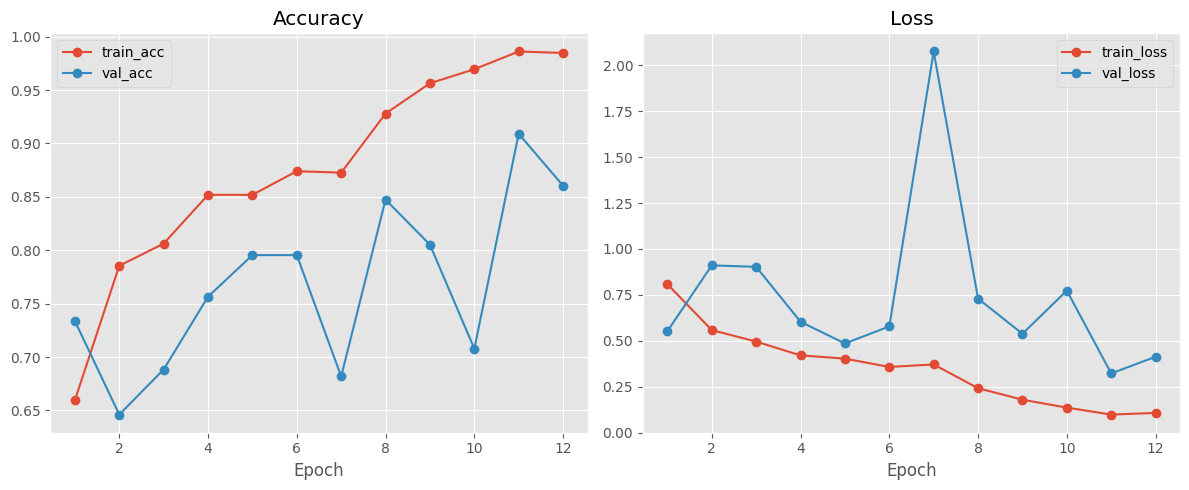

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.8805 - loss: 0.7287

Test accuracy: 0.9226, Test loss: 0.4256
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step


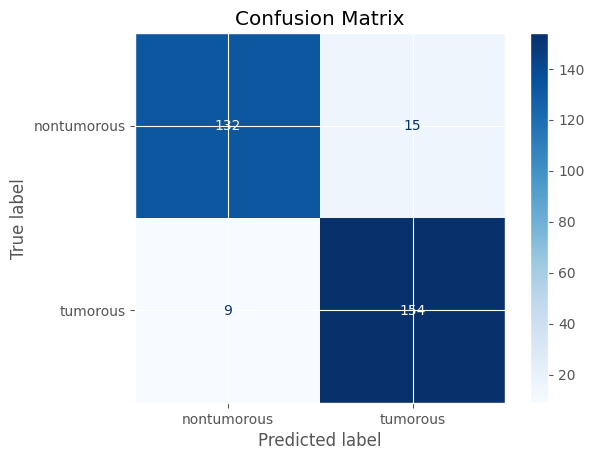

              precision    recall  f1-score   support

 nontumorous       0.94      0.90      0.92       147
    tumorous       0.91      0.94      0.93       163

    accuracy                           0.92       310
   macro avg       0.92      0.92      0.92       310
weighted avg       0.92      0.92      0.92       310



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Imports & Loss
# ──────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# ──────────────────────────────────────────────────────────────────────────────
# 2) Paths & Hyperparams
# ──────────────────────────────────────────────────────────────────────────────
train_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/train/"
valid_dir = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/valid/"
test_dir  = "/content/drive/My Drive/Braintumordetection/tumorous_and_nontumorous/test/"

IMG_SIZE   = (240, 240)
BATCH_SIZE = 32
SEED       = 42

# ──────────────────────────────────────────────────────────────────────────────
# 3) Data Generators (with zoom & brightness)
# ──────────────────────────────────────────────────────────────────────────────
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True, seed=SEED
)
valid_generator = val_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False, seed=SEED
)
test_generator = val_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False, seed=SEED
)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Compute Balanced Class Weights
# ──────────────────────────────────────────────────────────────────────────────
y_train = train_generator.classes
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Build VGG19 + Regularized Head
# ──────────────────────────────────────────────────────────────────────────────
base = VGG19(weights='imagenet', include_top=False,
             input_shape=(*IMG_SIZE, 3))
base.trainable = False

x = base.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=out)
model.summary()

# ──────────────────────────────────────────────────────────────────────────────
# 6) Callbacks: monitor val_accuracy & val_loss
# ──────────────────────────────────────────────────────────────────────────────
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('vgg19_tight_best.keras', save_best_only=True)
]

# ──────────────────────────────────────────────────────────────────────────────
# 7) Stage 1: Train Head Only
# ──────────────────────────────────────────────────────────────────────────────
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_head = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks
)

# ──────────────────────────────────────────────────────────────────────────────
# 8) Stage 2: Fine-Tune ONLY block5 of VGG19
# ──────────────────────────────────────────────────────────────────────────────
for layer in base.layers:
    layer.trainable = layer.name.startswith('block5_')

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_ft = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks
)

# ──────────────────────────────────────────────────────────────────────────────
# 9) Plot Training Curves
# ──────────────────────────────────────────────────────────────────────────────
def plot_hist(h1, h2):
    acc     = h1.history['accuracy']    + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss    = h1.history['loss']        + h2.history['loss']
    val_loss= h1.history['val_loss']    + h2.history['val_loss']
    epochs  = range(1, len(acc)+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,    'o-', label='train_acc')
    plt.plot(epochs, val_acc,'o-', label='val_acc')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss,    'o-', label='train_loss')
    plt.plot(epochs, val_loss,'o-', label='val_loss')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()

    plt.tight_layout(); plt.show()

plot_hist(history_head, history_ft)

# ──────────────────────────────────────────────────────────────────────────────
# 10) Final Evaluation & Confusion Matrix
# ──────────────────────────────────────────────────────────────────────────────
model.load_weights('vgg19_tight_best.keras')
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

probs = model.predict(test_generator)
preds = (probs > 0.5).astype(int).ravel()
y_true = test_generator.classes

cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot(cmap='Blues'); plt.title("Confusion Matrix"); plt.show()

print(classification_report(y_true, preds, target_names=list(train_generator.class_indices.keys())))
